# Black-Scholes Option Pricing - Implied Volatility Surface Analysis




This notebook implements Black-Scholes option pricing model with implied volatility (IV) surface analysis.




## **I - Key Features**

### **I1. Core Functionality**
- **Black-Scholes Option Pricing**: Calculates theoretical call and put option prices with dividend yield adjustment
- **Implied Volatility Calculation**: Three computational methods (Newton-Raphson, Brent's, and Hybrid)
- **Real Market Data Integration**: Real market data retrieval from Yahoo Finance API
- **Volatility Surface Generation**: 2D and 3D visualization of implied volatility patterns

### **2. Technical Capabilities**

| Feature | Description |
|---------|-------------|
| **Pricing Models** | Black-Scholes-Merton with continuous dividend yield |
| **Implied Volatility (IV) Algorithms** | Hybrid Newton-Raphson/Brent's method with adaptive bounds |
| **Greeks Calculation** | Vega computation for Newton-Raphson convergence |
| **Data Filtering** | Strike range, time-to-expiry, volume, and open interest filters |
| **Interpolation** | Cubic/linear griddata with Gaussian smoothing |
| **Error Metrics** | MAE, RMSE, MAPE for both price and IV accuracy |



## **II - Methodology**

### **1. Analysis Pipeline**

Data Acquisition → 2. Filtering → 3. IV Computation → 4. Pricing → 5. Validation → 6. Visualization

**Step 1: Market Data Retrieval**
- Fetches current spot price and historical data
- Retrieves options chain for multiple expiration dates
- Extracts bid-ask spreads, volume, and open interest

**Step 2: Data Quality Filtering**
- Strike range: 70-130% of spot price (configurable)
- Minimum time to expiry: 25 days
- Positive last traded price validation
- Optional volume/open interest thresholds

**Step 3: Implied Volatility Calculation**
- **Hybrid Method** (default): Attempts fast Newton-Raphson first, falls back to robust Brent's method
- **Initial Guess**: Brenner-Subrahmanyam approximation for ATM options
- **Convergence**: Tolerance of 1e-8 with maximum 150 iterations
- **Bounds**: Dynamic adjustment from 0.001 to 10.0 (1000% annualized)

**Step 4: Theoretical Pricing**
- Recalculates option prices using computed IV
- Generates price error metrics (absolute and percentage)
- Compares against market-quoted IV when available

**Step 5: Accuracy Validation**
- Computes error metrics for all options and ATM subset
- Statistical analysis: mean, median, RMSE, MAPE
- Identifies pricing discrepancies and arbitrage opportunities

**Step 6: Visualization**
- **2D Scatter Plots**: IV smile by strike and moneyness
- **3D Surface Plots**: Volatility surface across strike and time dimensions
- **Difference Maps**: Computed vs. market IV comparison


## **2. Accuracy Metrics**


### **Price Error Metrics**
- **MAE** (Mean Absolute Error): Average absolute pricing error in dollars
- **RMSE** (Root Mean Squared Error): Penalizes larger errors more heavily
- **MAPE** (Mean Absolute Percentage Error): Relative error as percentage
- **Median Error**: Robust central tendency measure

### **Implied Volatility Error Metrics** (when market Implied Volatility available)
- Comparison between computed and market-quoted implied volatility
- Identifies systematic biases in market pricing
- Highlights potential arbitrage opportunities

### **Segmented Analysis**
- **All Options**: Complete dataset statistics
- **ATM Options**: Focused analysis on ±15% moneyness range (configurable)


## 1. Import and Configuration

In [1]:
# Core numerical and data libraries
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.optimize import brentq
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Market data
import yfinance as yf

# Utilities
from datetime import datetime
import warnings

# ==================== CONFIGURATION ====================
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.style.use('bmh')

RANDOM_SEED = 3407
np.random.seed(RANDOM_SEED)

pd.set_option('display.precision', 6)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)

# ==================== CONSTANTS ====================
DAYS_PER_YEAR = 365.25  # 
MIN_TIME_TO_EXPIRY = 0.07  # Minimum ~25 days
DEFAULT_TOLERANCE = 1e-8
DEFAULT_MAX_ITERATIONS = 150
IV_SEARCH_BOUNDS = (0.001, 10.0)  # Wider bounds for exotic cases
MIN_SIGMA = 1e-10
MIN_PRICE_THRESHOLD = 1e-8
EPSILON = 1e-10  

## 2. Black-Scholes Pricing

In [2]:
def black_scholes_price(S, K, r, T, sigma, q=0.0, option_type='call'):
    """
    Calculate Black-Scholes option price with improved numerical stability.
    
    Parameters:
    -----------
    S : float - Current stock price
    K : float - Strike price
    r : float - Risk-free interest rate
    T : float - Time to expiration in years
    sigma : float - Volatility
    q : float - Dividend yield (default: 0.0)
    option_type : str - 'call' or 'put'
    
    Returns:
    --------
    float - Option price
    """
    # Handle expiration
    if T <= EPSILON:
        intrinsic = max(S - K, 0) if option_type.lower() in ['call', 'c'] else max(K - S, 0)
        return intrinsic
    
    # Input validation
    if S <= 0 or K <= 0 or sigma < 0:
        return 0.0
    
    # Ensure minimum volatility for numerical stability
    sigma = max(sigma, MIN_SIGMA)
    
    try:
        # Calculate d1 and d2
        sqrt_T = sigma * np.sqrt(T)
        # Fix: Handle division by zero when sqrt_T is 0
        if sqrt_T <= EPSILON:
            intrinsic = max(S - K, 0) if option_type.lower() in ['call', 'c'] else max(K - S, 0)
            return intrinsic
            
        d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / sqrt_T
        d2 = d1 - sqrt_T
        
        # Calculate price based on option type
        discount_factor = np.exp(-r * T)
        dividend_factor = np.exp(-q * T)
        
        if option_type.lower() in ['call', 'c']:
            price = S * dividend_factor * norm.cdf(d1) - K * discount_factor * norm.cdf(d2)
        else:
            price = K * discount_factor * norm.cdf(-d2) - S * dividend_factor * norm.cdf(-d1)
        
        return max(price, 0.0)  # Ensure non-negative
    
    except (ValueError, ZeroDivisionError, OverflowError, FloatingPointError):
        # Return intrinsic value on error
        intrinsic = max(S - K, 0) if option_type.lower() in ['call', 'c'] else max(K - S, 0)
        return intrinsic


def black_scholes_call(S, K, r, T, sigma, q=0.0):
    """Calculate Black-Scholes call option price."""
    return black_scholes_price(S, K, r, T, sigma, q, 'call')


def black_scholes_put(S, K, r, T, sigma, q=0.0):
    """Calculate Black-Scholes put option price."""
    return black_scholes_price(S, K, r, T, sigma, q, 'put')


def black_scholes_vega(S, K, r, T, sigma, q=0.0):
    """
    Calculate Black-Scholes Vega (derivative of price with respect to volatility).
    
    Parameters:
    -----------
    S : float - Current stock price
    K : float - Strike price
    r : float - Risk-free interest rate
    T : float - Time to expiration in years
    sigma : float - Volatility
    q : float - Dividend yield
    
    Returns:
    --------
    float - Vega value
    """
    if T <= EPSILON or S <= 0 or K <= 0:
        return EPSILON
    
    sigma = max(sigma, MIN_SIGMA)
    
    try:
        sqrt_T = sigma * np.sqrt(T)
        if sqrt_T <= EPSILON: 
            return EPSILON
            
        d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / sqrt_T
        
        vega = S * np.exp(-q * T) * norm.pdf(d1) * np.sqrt(T)
        return max(vega, EPSILON)  # Ensure positive vega
    
    except (ValueError, ZeroDivisionError, OverflowError, FloatingPointError):
        return EPSILON

## 3. Implied Volatility

In [3]:
def calculate_iv_newton(S, K, r, T, market_price, option_type, q=0.0,
                                       initial_guess=0.3, max_iterations=50, tolerance=1e-8):
    """
    Calculate implied volatility using Newton-Raphson method with safeguards.
    
    Parameters:
    -----------
    S : float - Current stock price
    K : float - Strike price
    r : float - Risk-free interest rate
    T : float - Time to expiration in years
    market_price : float - Market price of the option
    option_type : str - 'call' or 'put'
    q : float - Dividend yield
    initial_guess : float - Initial volatility guess
    max_iterations : int - Maximum iterations
    tolerance : float - Convergence tolerance
    
    Returns:
    --------
    float - Implied volatility (or np.nan if calculation fails)
    """
    # Input validation
    if T <= EPSILON or market_price <= MIN_PRICE_THRESHOLD or S <= 0 or K <= 0:
        return np.nan
    
    option_type = option_type.lower()
    
    # Check intrinsic value
    intrinsic = max(S - K, 0) if option_type in ['call', 'c'] else max(K - S, 0)
    if market_price < intrinsic - tolerance:
        return np.nan
    
    # If at intrinsic value, return very low IV
    if abs(market_price - intrinsic) < tolerance:
        return 0.01
    
    sigma = initial_guess
    
    for iteration in range(max_iterations):
        # Calculate option price and vega
        price = black_scholes_price(S, K, r, T, sigma, q, option_type)
        vega = black_scholes_vega(S, K, r, T, sigma, q)
        
        # Price difference
        price_diff = price - market_price
        
        # Check convergence
        if abs(price_diff) < tolerance:
            return sigma if sigma > EPSILON else np.nan
        
        # Prevent division by very small vega
        if vega < EPSILON:
            return np.nan
        
        # Newton-Raphson update
        sigma_new = sigma - price_diff / vega
        
        # Apply bounds and damping for stability
        if sigma_new < 0.001:
            sigma_new = sigma * 0.5  # Damped reduction
        elif sigma_new > 10.0:
            sigma_new = min(sigma * 1.5, 15.0)  # Damped increase with upper bound
        
        # Check for convergence in sigma
        if abs(sigma_new - sigma) < tolerance:
            return sigma_new if sigma_new > EPSILON else np.nan
        
        sigma = sigma_new
    
    # If converged to reasonable value, return it
    if 0.001 < sigma < 10.0:
        final_price = black_scholes_price(S, K, r, T, sigma, q, option_type)
        if abs(final_price - market_price) < tolerance * 10:  # Relaxed tolerance
            return sigma
    
    return np.nan


def calculate_iv_brent(S, K, r, T, market_price, option_type, q=0.0,
                                      a=0.001, b=10.0, tolerance=1e-8):
    """
    Calculate implied volatility using Brent's method.
    
    Parameters:
    -----------
    S : float - Current stock price
    K : float - Strike price
    r : float - Risk-free interest rate
    T : float - Time to expiration in years
    market_price : float - Market price of the option
    option_type : str - 'call' or 'put'
    q : float - Dividend yield
    a : float - Lower bound for IV search
    b : float - Upper bound for IV search
    tolerance : float - Convergence tolerance
    
    Returns:
    --------
    float - Implied volatility (or np.nan if calculation fails)
    """
    # Input validation
    if T <= EPSILON or market_price <= MIN_PRICE_THRESHOLD or S <= 0 or K <= 0:
        return np.nan
    
    option_type = option_type.lower()
    
    # Check intrinsic value
    intrinsic = max(S - K, 0) if option_type in ['call', 'c'] else max(K - S, 0)
    if market_price < intrinsic - tolerance:
        return np.nan
    
    # Define objective function
    def objective(sigma):
        return market_price - black_scholes_price(S, K, r, T, sigma, q, option_type)
    
    # Check if bounds bracket the root
    try:
        f_a = objective(a)
        f_b = objective(b)
        
        # If bounds don't bracket, try to find better bounds
        if f_a * f_b > 0:
            # Try wider bounds
            if f_a > 0:  # Need higher volatility
                b = min(b * 2, 15.0)
            else:  # Need lower volatility
                a = max(a / 2, 0.0001)
            
            f_a = objective(a)
            f_b = objective(b)
            
            # If still don't bracket, return NaN
            if f_a * f_b > 0:
                return np.nan
        
        # Use Brent's method
        result = brentq(objective, a=a, b=b, xtol=tolerance, maxiter=DEFAULT_MAX_ITERATIONS)
        return result if result > EPSILON else np.nan
    
    except (ValueError, RuntimeError):
        return np.nan


def calculate_iv(S, K, r, T, market_price, option_type, q=0.0,
                                 method='hybrid', tolerance=DEFAULT_TOLERANCE):
    """
    Calculate implied volatility using hybrid approach for robustness.
    
    Parameters:
    -----------
    S : float - Current stock price
    K : float - Strike price
    r : float - Risk-free interest rate
    T : float - Time to expiration in years
    market_price : float - Market price of the option
    option_type : str - 'call' or 'put'
    q : float - Dividend yield
    method : str - 'newton', 'brent', or 'hybrid'
    tolerance : float - Convergence tolerance
    
    Returns:
    --------
    float - Implied volatility (or np.nan if calculation fails)
    """
    # Input validation
    if T <= EPSILON or market_price <= MIN_PRICE_THRESHOLD or S <= 0 or K <= 0:
        return np.nan
    
    option_type = option_type.lower()
    if option_type not in ['call', 'put', 'c', 'p']:
        return np.nan
    
    # Calculate initial guess based on ATM approximation
    moneyness = K / S
    time_factor = np.sqrt(T)
    
    # Better initial guess using Brenner-Subrahmanyam approximation
    if abs(moneyness - 1.0) < 0.05 and time_factor > EPSILON:  # Near ATM
        # Fix: Handle division by near-zero time_factor
        initial_guess = np.sqrt(2 * np.pi / T) * (market_price / S) if T > EPSILON else 0.3
    else:
        initial_guess = 0.3  # Default guess
    
    initial_guess = np.clip(initial_guess, 0.05, 2.0)
    
    if method == 'newton':
        return calculate_iv_newton(
            S, K, r, T, market_price, option_type, q, initial_guess, 
            max_iterations=100, tolerance=tolerance
        )
    
    elif method == 'brent':
        return calculate_iv_brent(
            S, K, r, T, market_price, option_type, q, 
            a=0.001, b=10.0, tolerance=tolerance
        )
    
    else:  # hybrid method (default)
        # Try Newton-Raphson first (faster)
        iv_newton = calculate_iv_newton(
            S, K, r, T, market_price, option_type, q, initial_guess,
            max_iterations=50, tolerance=tolerance
        )
        
        if not np.isnan(iv_newton) and 0.001 < iv_newton < 10.0:
            # Verify the result
            test_price = black_scholes_price(S, K, r, T, iv_newton, q, option_type)
            if abs(test_price - market_price) < tolerance * 10:
                return iv_newton
        
        # Fall back to Brent's method if Newton fails
        iv_brent = calculate_iv_brent(
            S, K, r, T, market_price, option_type, q,
            a=0.001, b=10.0, tolerance=tolerance
        )
        
        return iv_brent

## 4. Utility  

In [4]:
def calculate_time_to_expiration(expiration_date, current_date=None):
    """
    Calculate time to expiration in years.
    
    Parameters:
    -----------
    expiration_date : str or datetime - Expiration date
    current_date : datetime - Current date (default: today)
    
    Returns:
    --------
    float - Time to expiration in years
    """
    if current_date is None:
        current_date = datetime.now()
    
    if isinstance(expiration_date, str):
        try:
            # Fix: Handle different date formats
            for fmt in ["%Y-%m-%d", "%Y%m%d", "%m/%d/%Y"]:
                try:
                    expiration_date = datetime.strptime(expiration_date, fmt)
                    break
                except ValueError:
                    continue
            if isinstance(expiration_date, str):
                return 0.0
        except (ValueError, TypeError):
            return 0.0
    
    try:
        days_to_expiration = (expiration_date - current_date).days
        # Use more accurate day count
        time_to_expiry = max(days_to_expiration / DAYS_PER_YEAR, 0)
        return time_to_expiry
    except (TypeError, AttributeError):
        return 0.0


def calculate_moneyness(S, K):
    """
    Calculate moneyness as Strike/Spot ratio.
    
    Parameters:
    -----------
    S : float - Current stock price
    K : float - Strike price
    
    Returns:
    --------
    float - Moneyness ratio
    """
    return K / S if S > 0 else np.nan


def calculate_log_moneyness(S, K):
    """
    Calculate log-moneyness: ln(K/S).
    
    Parameters:
    -----------
    S : float - Current stock price
    K : float - Strike price
    
    Returns:
    --------
    float - Log-moneyness
    """
    if S > 0 and K > 0:
        return np.log(K / S)
    return np.nan

## 5. Data Retrieval

In [5]:
def get_stock_data(ticker_symbol, period="1y"):
    """
    Retrieve stock data from Yahoo Finance.
    
    Parameters:
    -----------
    ticker_symbol : str - Stock ticker symbol
    period : str - Historical data period
    
    Returns:
    --------
    tuple - (ticker object, historical prices DataFrame, current spot price)
    """
    try:
        stock = yf.Ticker(ticker_symbol)
        spot_prices = stock.history(period=period)
        
        if spot_prices.empty:
            raise ValueError(f"No historical data available for ticker {ticker_symbol}")
        
        # Get current spot price
        spot_price = spot_prices["Close"].iloc[-1]
        spot_prices_df = spot_prices[["Close"]].copy()
        
        return stock, spot_prices_df, float(spot_price)
    
    except Exception as e:
        raise ValueError(f"Error retrieving stock data for {ticker_symbol}: {str(e)}")


def get_options_data(stock, max_expirations=None):
    """
    Retrieve options chain data.
    
    Parameters:
    -----------
    stock : yfinance.Ticker - Ticker object
    max_expirations : int - Maximum number of expiration dates to retrieve
    
    Returns:
    --------
    tuple - (combined options DataFrame, list of expiration dates)
    """
    try:
        expiration_dates = stock.options
    except Exception as e:
        raise ValueError(f"Error retrieving expiration dates: {str(e)}")
    
    if not expiration_dates:
        raise ValueError("No expiration dates available")
    
    if max_expirations:
        expiration_dates = expiration_dates[:max_expirations]
    
    all_options = []
    successful_dates = []
    
    for date in expiration_dates:
        try:
            chain = stock.option_chain(date)
            
            # Process calls
            calls = chain.calls.copy()
            calls['expiration'] = date
            calls['option_type'] = 'call'
            all_options.append(calls)
            
            # Process puts
            puts = chain.puts.copy()
            puts['expiration'] = date
            puts['option_type'] = 'put'
            all_options.append(puts)
            
            successful_dates.append(date)
            
        except Exception as e:
            print(f"Warning: Could not retrieve options for {date}: {str(e)}")
            continue
    
    if not all_options:
        raise ValueError("No options data retrieved")
    
    options_df = pd.concat(all_options, ignore_index=True)
    
    return options_df, successful_dates


def filter_options_data(options_data, spot_price, min_strike_pct=0.7, 
                       max_strike_pct=1.3, min_time_to_expiry=MIN_TIME_TO_EXPIRY,
                       min_volume=0, min_open_interest=0):
    """
    Filter options data based on multiple criteria.
    
    Parameters:
    -----------
    options_data : DataFrame - Options data
    spot_price : float - Current stock price
    min_strike_pct : float - Minimum strike as percentage of spot
    max_strike_pct : float - Maximum strike as percentage of spot
    min_time_to_expiry : float - Minimum time to expiration in years
    min_volume : int - Minimum volume filter
    min_open_interest : int - Minimum open interest filter
    
    Returns:
    --------
    DataFrame - Filtered options data
    """
    if options_data.empty:
        return pd.DataFrame()
    
    # Calculate strike bounds
    min_strike = spot_price * min_strike_pct
    max_strike = spot_price * max_strike_pct
    
    # Create a copy to avoid SettingWithCopyWarning
    options_data = options_data.copy()
    
    # Calculate time to expiration
    options_data['time_to_expiry'] = options_data['expiration'].apply(
        calculate_time_to_expiration
    )
    
    # Apply filters efficiently
    mask = (
        (options_data['strike'] >= min_strike) & 
        (options_data['strike'] <= max_strike) &
        (options_data['time_to_expiry'] >= min_time_to_expiry) &
        (options_data['lastPrice'] > MIN_PRICE_THRESHOLD) &
        (options_data['strike'] > 0)
    )
    
    # Add volume and open interest filters if specified
    if min_volume > 0:
        mask &= (options_data.get('volume', 0) >= min_volume)
    
    if min_open_interest > 0:
        mask &= (options_data.get('openInterest', 0) >= min_open_interest)
    
    filtered = options_data[mask].copy()
    
    return filtered.reset_index(drop=True)

## 6. Implied Volatility Calculation

In [6]:
def compute_iv_for_options(options_data, spot_price, risk_free_rate, dividend_yield=0.0,
                          method='hybrid'):
    """
    Compute implied volatility for all options.
    
    Parameters:
    -----------
    options_data : DataFrame - Filtered options data
    spot_price : float - Current stock price
    risk_free_rate : float - Risk-free interest rate
    dividend_yield : float - Dividend yield
    method : str - IV calculation method ('newton', 'brent', 'hybrid')
    
    Returns:
    --------
    DataFrame - Options data with computed IV
    """
    if options_data.empty:
        return pd.DataFrame()
    
    results = []
    total = len(options_data)
    success_count = 0
    
    for idx, row in options_data.iterrows():
        strike = row['strike']
        time_to_expiry = row['time_to_expiry']
        market_price = row['lastPrice']
        option_type = row['option_type']
        
        # Skip invalid data
        if time_to_expiry <= 0 or market_price <= 0 or strike <= 0:
            continue
        
        # Calculate IV
        iv = calculate_iv(
            S=spot_price,
            K=strike,
            r=risk_free_rate,
            T=time_to_expiry,
            market_price=market_price,
            option_type=option_type,
            q=dividend_yield,
            method=method
        )
        
        # Only include valid results
        if not np.isnan(iv) and 0.001 < iv < 10.0:
            results.append({
                'contract_symbol': row.get('contractSymbol', ''),
                'strike': strike,
                'time_to_expiry': time_to_expiry,
                'option_type': option_type,
                'market_price': market_price,
                'implied_volatility': iv,
                'moneyness': calculate_moneyness(spot_price, strike),
                'log_moneyness': calculate_log_moneyness(spot_price, strike),
                'market_iv': row.get('impliedVolatility', np.nan),
                'volume': row.get('volume', 0),
                'openInterest': row.get('openInterest', 0),
                'bid': row.get('bid', np.nan),
                'ask': row.get('ask', np.nan)
            })
            success_count += 1
    
    result_df = pd.DataFrame(results)
    
    if not result_df.empty:
        print(f"  IV computation success rate: {success_count}/{total} ({100*success_count/total:.1f}%)")
    
    return result_df

## 7. Theoretical Pricing & Comparison

In [7]:
def calculate_theoretical_prices(iv_data, spot_price, risk_free_rate, dividend_yield=0.0):
    """
    Calculate theoretical option prices using computed IVs.
    
    Parameters:
    -----------
    iv_data : DataFrame - Data with computed IVs
    spot_price : float - Current stock price
    risk_free_rate : float - Risk-free interest rate
    dividend_yield : float - Dividend yield
    
    Returns:
    --------
    DataFrame - Data with theoretical prices and errors
    """
    if iv_data.empty:
        return pd.DataFrame()
    
    iv_data = iv_data.copy(deep=True)
    
    theoretical_prices = []
    for idx, row in iv_data.iterrows():
        theo_price = black_scholes_price(
            S=spot_price,
            K=row['strike'],
            r=risk_free_rate,
            T=row['time_to_expiry'],
            sigma=row['implied_volatility'],
            q=dividend_yield,
            option_type=row['option_type']
        )
        theoretical_prices.append(theo_price)
    
    iv_data['theoretical_price'] = theoretical_prices
    iv_data['price_error'] = np.abs(iv_data['theoretical_price'] - iv_data['market_price'])
    iv_data['price_error_pct'] = (iv_data['price_error'] / iv_data['market_price']) * 100
    
    # Calculate relative price error
    iv_data['relative_error'] = (iv_data['theoretical_price'] - iv_data['market_price']) / iv_data['market_price']
    
    # Calculate IV error only where market IV is available
    iv_data['iv_error'] = np.where(
        iv_data['market_iv'].notna(),
        iv_data['implied_volatility'] - iv_data['market_iv'],
        np.nan
    )
    
    iv_data['iv_error_pct'] = np.where(
        iv_data['market_iv'].notna(),
        (iv_data['iv_error'] / iv_data['market_iv']) * 100,
        np.nan
    )
    
    return iv_data


def calculate_accuracy_metrics(comparison_df):
    """
    Calculate comprehensive accuracy metrics for IV and pricing errors.
    
    Parameters:
    -----------
    comparison_df : DataFrame - Comparison data with errors
    
    Returns:
    --------
    dict - Dictionary of accuracy metrics
    """
    if comparison_df.empty:
        return {
            'mae_iv': np.nan,
            'rmse_iv': np.nan,
            'mae_price': np.nan,
            'rmse_price': np.nan,
            'mape_price': np.nan,
            'count': 0
        }
    
    valid_data = comparison_df.dropna(subset=['price_error'])
    valid_iv = comparison_df.dropna(subset=['iv_error'])
    
    if len(valid_data) == 0:
        return {
            'mae_iv': np.nan,
            'rmse_iv': np.nan,
            'mae_price': np.nan,
            'rmse_price': np.nan,
            'mape_price': np.nan,
            'count': 0
        }
    
    metrics = {
        'mae_price': valid_data['price_error'].mean(),
        'rmse_price': np.sqrt((valid_data['price_error'] ** 2).mean()),
        'mape_price': valid_data['price_error_pct'].mean(),
        'median_error_price': valid_data['price_error'].median(),
        'count': len(valid_data)
    }
    
    # Add IV metrics if available
    if len(valid_iv) > 0:
        metrics.update({
            'mae_iv': valid_iv['iv_error'].abs().mean(),
            'rmse_iv': np.sqrt((valid_iv['iv_error'] ** 2).mean()),
            'mape_iv': valid_iv['iv_error_pct'].abs().mean(),
            'median_error_iv': valid_iv['iv_error'].abs().median(),
        })
    else:
        metrics.update({
            'mae_iv': np.nan,
            'rmse_iv': np.nan,
            'mape_iv': np.nan,
            'median_error_iv': np.nan,
        })
    
    return metrics

## 8. Visualization 

In [8]:
def create_iv_surface_grid(iv_data, x_col='time_to_expiry', y_col='moneyness', 
                          z_col='implied_volatility', grid_size=50, smooth_sigma=0.5):
    """
    Create interpolated grid for IV surface plotting.
    
    Parameters:
    -----------
    iv_data : DataFrame - IV data
    x_col : str - Column name for X axis
    y_col : str - Column name for Y axis
    z_col : str - Column name for Z axis
    grid_size : int - Grid resolution
    smooth_sigma : float - Gaussian smoothing parameter
    
    Returns:
    --------
    tuple - (X_grid, Y_grid, Z_grid)
    """
    if iv_data.empty or len(iv_data) < 4:
        return None, None, None
    
    # Extract and clean data
    valid_data = iv_data[[x_col, y_col, z_col]].dropna()
    
    if len(valid_data) < 4:
        return None, None, None
    
    X = valid_data[x_col].values
    Y = valid_data[y_col].values
    Z = valid_data[z_col].values
    
    # Remove outliers (optional but helpful)
    z_median = np.median(Z)
    z_std = np.std(Z)
    mask = np.abs(Z - z_median) < 3 * z_std
    X, Y, Z = X[mask], Y[mask], Z[mask]
    
    if len(X) < 4:
        return None, None, None
    
    # Create grid with padding
    x_range = X.max() - X.min()
    y_range = Y.max() - Y.min()
    x_pad = x_range * 0.05
    y_pad = y_range * 0.05
    
    x_grid = np.linspace(X.min() - x_pad, X.max() + x_pad, grid_size)
    y_grid = np.linspace(Y.min() - y_pad, Y.max() + y_pad, grid_size)
    X_grid, Y_grid = np.meshgrid(x_grid, y_grid)
    
    # Interpolate with fallback methods
    Z_grid = None
    
    try:
        # Try cubic interpolation first
        Z_grid = griddata((X, Y), Z, (X_grid, Y_grid), method='cubic')
        
        # If too many NaNs, try linear
        if np.isnan(Z_grid).sum() > Z_grid.size * 0.3:
            Z_grid = griddata((X, Y), Z, (X_grid, Y_grid), method='linear')
    
    except Exception:
        try:
            # Fallback to linear
            Z_grid = griddata((X, Y), Z, (X_grid, Y_grid), method='linear')
        except Exception:
            return None, None, None
    
    # Apply smoothing if requested and data is valid
    if smooth_sigma > 0 and Z_grid is not None and not np.all(np.isnan(Z_grid)):
        # Create mask for valid data
        valid_mask = ~np.isnan(Z_grid)
        
        if valid_mask.sum() > 0:
            # Fill NaNs with nearest neighbor for smoothing
            Z_filled = Z_grid.copy()
            if np.isnan(Z_filled).any():
                try:
                    Z_filled = griddata((X, Y), Z, (X_grid, Y_grid), method='nearest')
                except Exception:
                    pass
            
            # Apply Gaussian filter
            try:
                Z_smoothed = gaussian_filter(Z_filled, sigma=smooth_sigma)
                # Restore NaN values outside the valid region
                Z_grid = np.where(valid_mask, Z_smoothed, np.nan)
            except Exception:
                pass
    
    return X_grid, Y_grid, Z_grid


def plot_iv_comparison_2d(iv_data, spot_price, figsize=(16, 7)):
    """
    Create enhanced 2D scatter plot comparing computed vs market IV.
    
    Parameters:
    -----------
    iv_data : DataFrame - IV data with both computed and market IVs
    spot_price : float - Current stock price
    figsize : tuple - Figure size
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    if iv_data.empty:
        for ax in [ax1, ax2]:
            ax.text(0.5, 0.5, 'No data available', horizontalalignment='center', 
                    verticalalignment='center', transform=ax.transAxes, fontsize=14)
        plt.tight_layout()
        return fig
    
    valid_data = iv_data.dropna(subset=['implied_volatility'])
    
    # Plot 1: IV by Strike
    if not valid_data.empty:
        calls = valid_data[valid_data['option_type'].isin(['call', 'c'])]
        puts = valid_data[valid_data['option_type'].isin(['put', 'p'])]
        
        if not calls.empty:
            ax1.scatter(calls['strike'], calls['implied_volatility'], 
                       label='Calls (Computed)', c='dodgerblue', s=60, alpha=0.7, 
                       marker='o', edgecolors='navy', linewidths=0.5)
        if not puts.empty:
            ax1.scatter(puts['strike'], puts['implied_volatility'], 
                       label='Puts (Computed)', c='coral', s=60, alpha=0.7, 
                       marker='s', edgecolors='darkred', linewidths=0.5)
        
        # Add market IV if available
        market_data = valid_data.dropna(subset=['market_iv'])
        if not market_data.empty:
            ax1.scatter(market_data['strike'], market_data['market_iv'], 
                       label='Market IV', c='limegreen', s=30, alpha=0.5, 
                       marker='x', linewidths=1.5)
    
    ax1.axvline(spot_price, color='black', linestyle='--', linewidth=2.5, 
                label=f'Spot: ${spot_price:.2f}', alpha=0.8)
    ax1.set_xlabel('Strike Price ($)', fontsize=13, fontweight='bold')
    ax1.set_ylabel('Implied Volatility', fontsize=13, fontweight='bold')
    ax1.set_title('Implied Volatility Smile by Strike', fontsize=15, fontweight='bold', pad=15)
    ax1.legend(loc='best', fontsize=10, framealpha=0.9)
    ax1.grid(True, alpha=0.3, linestyle='--')
    
    # Plot 2: IV by Moneyness
    if not valid_data.empty:
        scatter = ax2.scatter(valid_data['moneyness'], valid_data['implied_volatility'], 
                             c=valid_data['time_to_expiry'], cmap='viridis', 
                             s=70, alpha=0.7, edgecolors='black', linewidths=0.5)
        cbar = plt.colorbar(scatter, ax=ax2)
        cbar.set_label('Time to Expiry (years)', fontsize=11, fontweight='bold')
        cbar.ax.tick_params(labelsize=9)
    
    ax2.axvline(1.0, color='black', linestyle='--', linewidth=2.5, 
                label='ATM', alpha=0.8)
    ax2.set_xlabel('Moneyness (K/S)', fontsize=13, fontweight='bold')
    ax2.set_ylabel('Implied Volatility', fontsize=13, fontweight='bold')
    ax2.set_title('Implied Volatility Surface by Moneyness', fontsize=15, fontweight='bold', pad=15)
    ax2.legend(loc='best', fontsize=10, framealpha=0.9)
    ax2.grid(True, alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    return fig


def plot_iv_surfaces_3d(iv_data, spot_price, figsize=(20, 6)):
    """
    Create enhanced 3D surface plots.
    
    Parameters:
    -----------
    iv_data : DataFrame - IV data
    spot_price : float - Current stock price
    figsize : tuple - Figure size
    """
    fig = plt.figure(figsize=figsize)
    
    # Separate calls and puts for better visualization
    calls_data = iv_data[iv_data['option_type'].isin(['call', 'c'])].copy()
    puts_data = iv_data[iv_data['option_type'].isin(['put', 'p'])].copy()
    
    # Create grids for computed IV (all data)
    X_comp, Y_comp, Z_comp = create_iv_surface_grid(
        iv_data, 
        x_col='time_to_expiry', 
        y_col='moneyness', 
        z_col='implied_volatility',
        grid_size=50,
        smooth_sigma=0.7
    )
    
    # Create grids for market IV (only where available)
    market_data = iv_data.dropna(subset=['market_iv']).copy()
    X_mkt, Y_mkt, Z_mkt = None, None, None
    
    if not market_data.empty and len(market_data) >= 4:
        X_mkt, Y_mkt, Z_mkt = create_iv_surface_grid(
            market_data, 
            x_col='time_to_expiry', 
            y_col='moneyness', 
            z_col='market_iv',
            grid_size=50,
            smooth_sigma=0.7
        )
    
    # Plot 1: Computed IV Surface
    ax1 = fig.add_subplot(1, 3, 1, projection='3d')
    
    if X_comp is not None and Z_comp is not None and not np.all(np.isnan(Z_comp)):
        # Mask out NaN values
        Z_comp_masked = np.ma.masked_invalid(Z_comp)
        
        surf1 = ax1.plot_surface(X_comp, Y_comp, Z_comp_masked, 
                                 cmap='viridis', alpha=0.85, 
                                 rstride=1, cstride=1, 
                                 linewidth=0.2, antialiased=True,
                                 edgecolor='gray')
        
        # Add colorbar with error handling
        try:
            cbar1 = fig.colorbar(surf1, ax=ax1, shrink=0.6, aspect=10, pad=0.1)
            cbar1.set_label('Implied Volatility', fontsize=10, fontweight='bold')
        except Exception:
            pass
    else:
        ax1.text2D(0.5, 0.5, 'Insufficient data', transform=ax1.transAxes,
                   ha='center', va='center', fontsize=12)
    
    ax1.set_title('Computed IV Surface', fontsize=13, fontweight='bold', pad=20)
    ax1.set_xlabel('Time to Expiry (years)', fontsize=10, labelpad=10)
    ax1.set_ylabel('Moneyness (K/S)', fontsize=10, labelpad=10)
    ax1.set_zlabel('Implied Volatility', fontsize=10, labelpad=10)
    ax1.view_init(elev=20, azim=45)
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Market IV Surface
    ax2 = fig.add_subplot(1, 3, 2, projection='3d')
    
    if X_mkt is not None and Z_mkt is not None and not np.all(np.isnan(Z_mkt)):
        # Mask out NaN values
        Z_mkt_masked = np.ma.masked_invalid(Z_mkt)
        
        surf2 = ax2.plot_surface(X_mkt, Y_mkt, Z_mkt_masked, 
                                 cmap='plasma', alpha=0.85, 
                                 rstride=1, cstride=1, 
                                 linewidth=0.2, antialiased=True,
                                 edgecolor='gray')
        
        # Add colorbar with error handling
        try:
            cbar2 = fig.colorbar(surf2, ax=ax2, shrink=0.6, aspect=10, pad=0.1)
            cbar2.set_label('Implied Volatility', fontsize=10, fontweight='bold')
        except Exception:
            pass
    else:
        ax2.text2D(0.5, 0.5, 'No market IV data', transform=ax2.transAxes,
                   ha='center', va='center', fontsize=12)
    
    ax2.set_title('Market IV Surface', fontsize=13, fontweight='bold', pad=20)
    ax2.set_xlabel('Time to Expiry (years)', fontsize=10, labelpad=10)
    ax2.set_ylabel('Moneyness (K/S)', fontsize=10, labelpad=10)
    ax2.set_zlabel('Implied Volatility', fontsize=10, labelpad=10)
    ax2.view_init(elev=20, azim=45)
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Difference Surface (FIXED BUG HERE)
    ax3 = fig.add_subplot(1, 3, 3, projection='3d')
    
    # Check if both surfaces are valid and compatible
    if (X_comp is not None and Z_comp is not None and 
        X_mkt is not None and Z_mkt is not None and
        not np.all(np.isnan(Z_comp)) and not np.all(np.isnan(Z_mkt))):
        
        # Fix: Ensure grids are the same shape by interpolating market IV onto computed grid
        try:
            # Flatten grids for interpolation
            X_comp_flat = X_comp.flatten()
            Y_comp_flat = Y_comp.flatten()
            X_mkt_flat = X_mkt.flatten()
            Y_mkt_flat = Y_mkt.flatten()
            Z_mkt_flat = Z_mkt.flatten()
            
            # Interpolate market IV onto computed grid
            Z_mkt_interp = griddata((X_mkt_flat, Y_mkt_flat), Z_mkt_flat, 
                                   (X_comp, Y_comp), method='linear')
            
            # Calculate difference
            Z_diff = Z_comp - Z_mkt_interp
            
            # Mask invalid values
            Z_diff_masked = np.ma.masked_invalid(Z_diff)
            
            # Only plot if we have valid data
            if not np.all(np.isnan(Z_diff_masked)):
                surf3 = ax3.plot_surface(X_comp, Y_comp, Z_diff_masked, 
                                         cmap='coolwarm', alpha=0.85, 
                                         rstride=1, cstride=1, 
                                         linewidth=0.2, antialiased=True,
                                         edgecolor='gray', vmin=-0.2, vmax=0.2)
                
                # Add colorbar with error handling
                try:
                    cbar3 = fig.colorbar(surf3, ax=ax3, shrink=0.6, aspect=10, pad=0.1)
                    cbar3.set_label('IV Difference', fontsize=10, fontweight='bold')
                except Exception:
                    pass
            else:
                ax3.text2D(0.5, 0.5, 'Cannot compute difference', transform=ax3.transAxes,
                           ha='center', va='center', fontsize=12)
        except Exception:
            ax3.text2D(0.5, 0.5, 'Interpolation failed', transform=ax3.transAxes,
                       ha='center', va='center', fontsize=12)
    else:
        ax3.text2D(0.5, 0.5, 'Incompatible surfaces', transform=ax3.transAxes,
                   ha='center', va='center', fontsize=12)
    
    ax3.set_title('IV Difference (Computed - Market)', fontsize=13, fontweight='bold', pad=20)
    ax3.set_xlabel('Time to Expiry (years)', fontsize=10, labelpad=10)
    ax3.set_ylabel('Moneyness (K/S)', fontsize=10, labelpad=10)
    ax3.set_zlabel('IV Difference', fontsize=10, labelpad=10)
    ax3.view_init(elev=20, azim=45)
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

## 9. Analysis Pipeline

In [9]:
def run_iv_analysis(ticker_symbol, risk_free_rate=0.036, dividend_yield=0.0,
                   min_strike_pct=0.7, max_strike_pct=1.3, 
                   max_expirations=5, atm_range=0.15, iv_method='hybrid'):
    """
    Run complete IV analysis pipeline.
    
    Parameters:
    -----------
    ticker_symbol : str - Stock ticker
    risk_free_rate : float - Risk-free rate
    dividend_yield : float - Dividend yield
    min_strike_pct : float - Min strike as % of spot
    max_strike_pct : float - Max strike as % of spot
    max_expirations : int - Max number of expirations to analyze
    atm_range : float - ATM range for metrics (e.g., 0.15 for ±15%)
    iv_method : str - IV calculation method ('newton', 'brent', 'hybrid')
    
    Returns:
    --------
    dict - Analysis results including data and metrics
    """
    print(f"\n{'='*75}")
    print(f"BLACK-SCHOLES IMPLIED VOLATILITY ANALYSIS: {ticker_symbol}")
    print(f"{'='*75}\n")
    
    # Step 1: Get stock data
    print("Step 1: Retrieving stock data...")
    try:
        stock, historical_prices, spot_price = get_stock_data(ticker_symbol)
        print(f"   Current spot price: ${spot_price:.2f}")
    except Exception as e:
        print(f"   Failed to retrieve stock data: {str(e)}")
        return None
    
    # Step 2: Get options data
    print("\nStep 2: Retrieving options chain...")
    try:
        options_data, expiration_dates = get_options_data(stock, max_expirations)
        print(f"   Retrieved {len(options_data)} option contracts")
        print(f"   Expiration dates analyzed: {len(expiration_dates)}")
        for i, date in enumerate(expiration_dates, 1):
            print(f"     {i}. {date}")
    except Exception as e:
        print(f"   Failed to retrieve options data: {str(e)}")
        return None
    
    # Step 3: Filter options
    print("\nStep 3: Filtering options data...")
    print(f"  - Strike range: {min_strike_pct*100:.0f}% - {max_strike_pct*100:.0f}% of spot")
    print(f"  - Min time to expiry: {MIN_TIME_TO_EXPIRY*365:.0f} days")
    filtered_options = filter_options_data(
        options_data, spot_price, min_strike_pct, max_strike_pct
    )
    print(f"   Filtered to {len(filtered_options)} contracts")
    
    if filtered_options.empty:
        print("   No options data after filtering")
        return None
    
    # Step 4: Compute IV
    print(f"\nStep 4: Computing implied volatilities (method: {iv_method})...")
    iv_data = compute_iv_for_options(
        filtered_options, spot_price, risk_free_rate, dividend_yield, method=iv_method
    )
    
    if iv_data.empty:
        print("  No IV data computed")
        return None
    
    # Print IV statistics
    print(f"\n  IV Statistics:")
    print(f"     - Mean IV:   {iv_data['implied_volatility'].mean():.4f}")
    print(f"     - Median IV: {iv_data['implied_volatility'].median():.4f}")
    print(f"     - Std Dev:   {iv_data['implied_volatility'].std():.4f}")
    print(f"     - Min IV:    {iv_data['implied_volatility'].min():.4f}")
    print(f"     - Max IV:    {iv_data['implied_volatility'].max():.4f}")
    
    # Step 5: Calculate theoretical prices
    print("\nStep 5: Calculating theoretical prices...")
    comparison_data = calculate_theoretical_prices(
        iv_data, spot_price, risk_free_rate, dividend_yield
    )
    print(f"   Theoretical prices computed for {len(comparison_data)} contracts")
    
    # Step 6: Calculate metrics
    print("\nStep 6: Calculating accuracy metrics...")
    metrics_all = calculate_accuracy_metrics(comparison_data)
    
    # ATM metrics
    atm_lower = spot_price * (1 - atm_range)
    atm_upper = spot_price * (1 + atm_range)
    atm_data = comparison_data[
        (comparison_data['strike'] >= atm_lower) & 
        (comparison_data['strike'] <= atm_upper)
    ].copy()
    metrics_atm = calculate_accuracy_metrics(atm_data)
    
    # Print metrics
    print("\n" + "="*75)
    print("ACCURACY METRICS - ALL TRADED OPTIONS")
    print("="*75)
    print(f"  Sample Size: {metrics_all['count']}")
    if metrics_all['count'] > 0:
        print(f"\n  Price Errors:")
        print(f"     - MAE (Mean Absolute Error):    ${metrics_all['mae_price']:.6f}")
        print(f"     - RMSE (Root Mean Squared):     ${metrics_all['rmse_price']:.6f}")
        print(f"     - MAPE (Mean Absolute % Error): {metrics_all['mape_price']:.4f}%")
        print(f"     - Median Error:                 ${metrics_all['median_error_price']:.6f}")
        
        if not np.isnan(metrics_all['mae_iv']):
            print(f"\n  IV Errors:")
            print(f"     - MAE (Mean Absolute Error):    {metrics_all['mae_iv']:.6f}")
            print(f"     - RMSE (Root Mean Squared):     {metrics_all['rmse_iv']:.6f}")
            print(f"     - MAPE (Mean Absolute % Error): {metrics_all['mape_iv']:.4f}%")
            print(f"     - Median Error:                 {metrics_all['median_error_iv']:.6f}")
    else:
        print("  No valid data for metrics calculation")
    
    print("\n" + "="*75)
    print(f"ACCURACY METRICS - ATM OPTIONS (±{atm_range*100:.0f}% Moneyness)")
    print("="*75)
    print(f"  Sample Size: {metrics_atm['count']}")
    if metrics_atm['count'] > 0:
        print(f"\n  Price Errors:")
        print(f"     - MAE (Mean Absolute Error):    ${metrics_atm['mae_price']:.6f}")
        print(f"     - RMSE (Root Mean Squared):     ${metrics_atm['rmse_price']:.6f}")
        print(f"     - MAPE (Mean Absolute % Error): {metrics_atm['mape_price']:.4f}%")
        print(f"     - Median Error:                 ${metrics_atm['median_error_price']:.6f}")
        
        if not np.isnan(metrics_atm['mae_iv']):
            print(f"\n  IV Errors:")
            print(f"     - MAE (Mean Absolute Error):    {metrics_atm['mae_iv']:.6f}")
            print(f"     - RMSE (Root Mean Squared):     {metrics_atm['rmse_iv']:.6f}")
            print(f"     - MAPE (Mean Absolute % Error): {metrics_atm['mape_iv']:.4f}%")
            print(f"     - Median Error:                 {metrics_atm['median_error_iv']:.6f}")
    else:
        print("  No ATM options available")
    
    print("\n" + "="*75)
    
    # Return results
    return {
        'ticker': ticker_symbol,
        'spot_price': spot_price,
        'risk_free_rate': risk_free_rate,
        'dividend_yield': dividend_yield,
        'iv_data': comparison_data,
        'atm_data': atm_data,
        'metrics_all': metrics_all,
        'metrics_atm': metrics_atm,
        'expiration_dates': expiration_dates
    }

## 10. Execution


BLACK-SCHOLES IMPLIED VOLATILITY ANALYSIS: A

Step 1: Retrieving stock data...
   Current spot price: $137.24

Step 2: Retrieving options chain...
   Retrieved 216 option contracts
   Expiration dates analyzed: 5
     1. 2026-01-16
     2. 2026-02-20
     3. 2026-03-20
     4. 2026-05-15
     5. 2026-06-18

Step 3: Filtering options data...
  - Strike range: 85% - 115% of spot
  - Min time to expiry: 26 days
   Filtered to 61 contracts

Step 4: Computing implied volatilities (method: hybrid)...
  IV computation success rate: 54/61 (88.5%)

  IV Statistics:
     - Mean IV:   0.3477
     - Median IV: 0.3035
     - Std Dev:   0.1356
     - Min IV:    0.1633
     - Max IV:    0.7731

Step 5: Calculating theoretical prices...
   Theoretical prices computed for 54 contracts

Step 6: Calculating accuracy metrics...

ACCURACY METRICS - ALL TRADED OPTIONS
  Sample Size: 54

  Price Errors:
     - MAE (Mean Absolute Error):    $0.000000
     - RMSE (Root Mean Squared):     $0.000000
     - MAPE

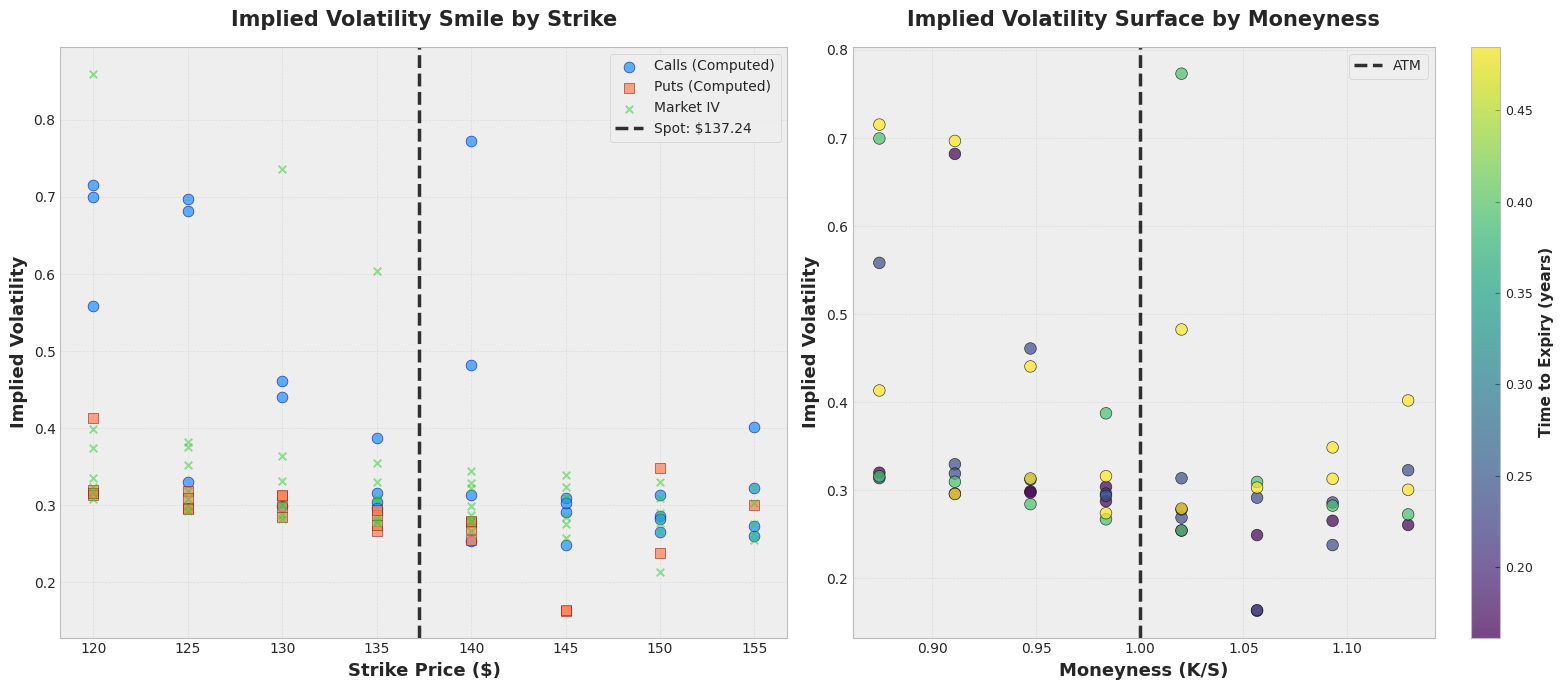

   2D plots created successfully

2. Creating 3D IV surface plots...


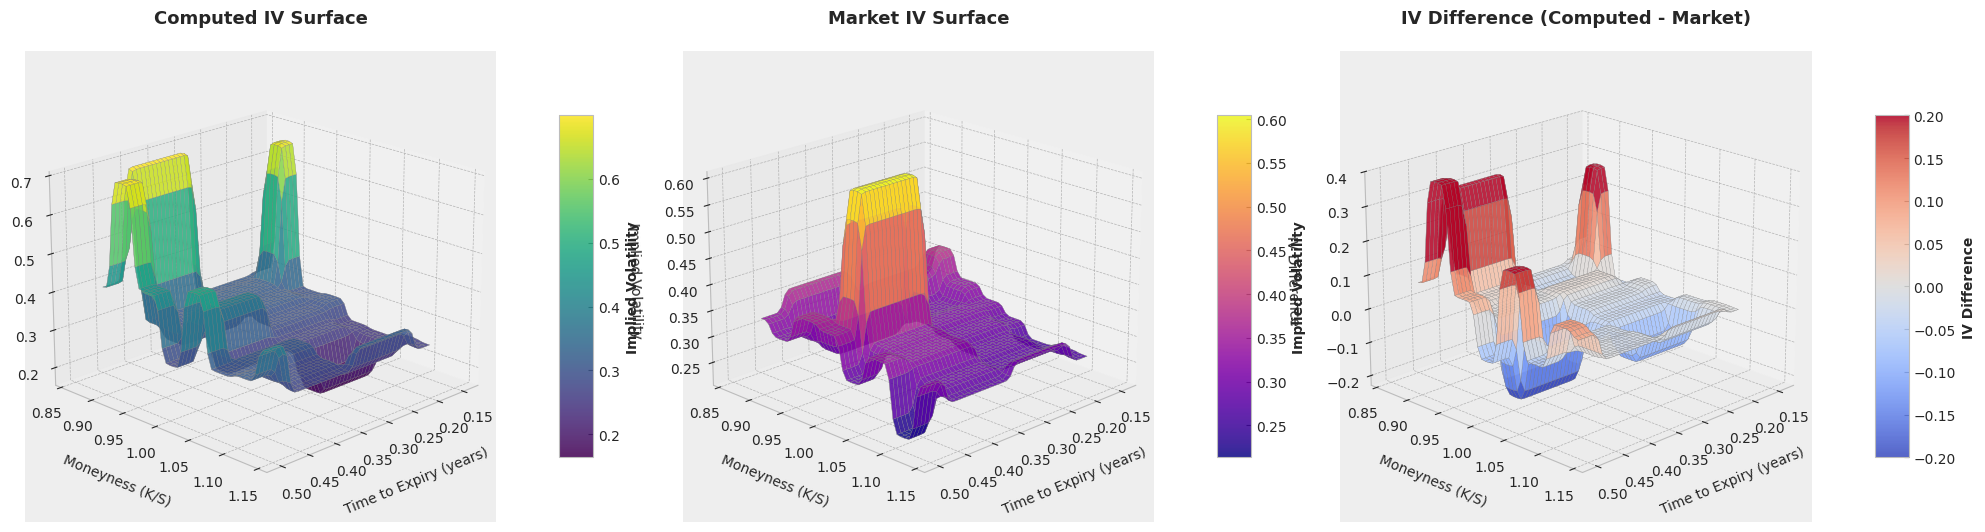

  3D surfaces created successfully

SAMPLE DATA - ATM OPTIONS
    strike option_type  time_to_expiry  market_price  implied_volatility  theoretical_price  price_error  price_error_pct
125.000000        call        0.161533     21.500000            0.681961          21.500000     0.000000         0.000000
125.000000         put        0.161533      1.800000            0.296163           1.800000     0.000000         0.000000
125.000000        call        0.238193     16.400000            0.329604          16.400000     0.000000         0.000000
125.000000         put        0.238193      3.200000            0.319035           3.200000     0.000000         0.000000
125.000000         put        0.391513      4.700000            0.309682           4.700000     0.000000         0.000000
125.000000        call        0.484600     32.300000            0.696670          32.300000     0.000000         0.000000
125.000000         put        0.484600      5.140000            0.295792           5

In [10]:
# Configuration
ticker_symbol = "A"  

# Run analysis
results = run_iv_analysis(
    ticker_symbol=ticker_symbol,
    risk_free_rate=0.036,
    dividend_yield=0.01,
    min_strike_pct=0.85,
    max_strike_pct=1.15,
    max_expirations=5,
    atm_range=0.12,
    iv_method='hybrid'  # Options: 'newton', 'brent', 'hybrid'
)

if results is None:
    print("\n Analysis failed. Please check the error messages above.")

# Create visualizations
print("\n" + "="*75)
print("GENERATING VISUALIZATIONS")
print("="*75)

print("\n1. Creating 2D IV comparison plots...")
try:
    fig_2d = plot_iv_comparison_2d(results['iv_data'], results['spot_price'])
    plt.show()
    print("   2D plots created successfully")
except Exception as e:
    print(f"   Error creating 2D plots: {str(e)}")

print("\n2. Creating 3D IV surface plots...")
try:
    fig_3d = plot_iv_surfaces_3d(results['iv_data'], results['spot_price'])
    plt.show()
    print("  3D surfaces created successfully")
except Exception as e:
    print(f"   Error creating 3D surfaces: {str(e)}")

# Display sample data
print("\n" + "="*75)
print("SAMPLE DATA - ATM OPTIONS")
print("="*75)

if not results['atm_data'].empty:
    display_cols = ['strike', 'option_type', 'time_to_expiry', 'market_price', 
                   'implied_volatility', 'theoretical_price', 'price_error', 
                   'price_error_pct']
    
    sample_data = results['atm_data'].sort_values('strike').head(20)
    
    # Format for better display
    pd.options.display.float_format = '{:.6f}'.format
    print(sample_data[display_cols].to_string(index=False))
else:
    print("No ATM options available")

print("\n" + "="*75)
print(" ANALYSIS COMPLETE")
print("="*75)

## References

1. **Global Association of Risk Professionals (2025).**  
   *FRM Part 1 Book 4: Valuation and Risk Models*, Chapter 15: The Black-Scholes-Merton Model, pp. 202-215.


***

**Github References**

1. https://github.com/George-Dros/Volatility_Surface/tree/main
2. https://github.com/ShresthaAbhishek/IV-Surface-Analysis